In [79]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import galsim as gs
from astropy.units import Unit as u
from astropy.units import deg
from pathlib import Path
from glob import glob
from astropy.coordinates import SkyCoord
from scipy.optimize import least_squares
import emcee
import corner

from kl_tools.utils import get_base_dir, build_map_grid
from kl_tools.velocity import VelocityMap
from kl_tools.kross.tfr import estimate_vtf
from kl_tools.priors import UniformPrior, GaussPrior
from matplotlib.colors import LogNorm

In [122]:
def get_kross_obj_data(kid, vb=False):
    kross_dir = get_base_dir() / 'data/kross'
    cosmo_dir = get_base_dir() / 'data/cosmos'
    kross_data = fitsio.read(kross_dir / 'kross_release_v2.fits', ext=1)

    # need all the coords for a match to the COSMOS cutouts
    kross_ra = kross_data['RA']
    kross_dec = kross_data['DEC']
    kross_names = kross_data['NAME']
    kross_coords = SkyCoord(ra=kross_ra*deg, dec=kross_dec*deg)

    # clean up the names
    for i, name in enumerate(kross_names):
        new = name.strip()
        kross_names[i] = new

    # get the KROSS sky coordinates to match to the COSMOS cutouts
    cosmo_files = glob(str(cosmo_dir / 'cutouts/*.fits'))
    cosmo_cutouts = {}
    for f in cosmo_files:
        fname = Path(f).name

        # match to the KROSS sky coordinates to get the obj name
        ra  = float(fname.split('_')[1])
        dec = float(fname.split('_')[2])
        coord = SkyCoord(ra=ra*deg, dec=dec*deg)

        indx, sep, _ = coord.match_to_catalog_sky(kross_coords)
        cosmo_cutouts[kross_names[indx]] = f

    row = kross_data[kross_data['KID'] == kid] 
    name = row['NAME'][0].strip()
    ra = kross_data['RA']
    dec = kross_data['DEC']

    cube_file = kross_dir / 'cubes' / f'{name}.fits'
    velocity_file = kross_dir / 'vmaps' / f'{name}.fits' 
    sigma_file = kross_dir / 'disp' / f'{name}.fits' 
    halpha_file = kross_dir / 'halpha' / f'{name}.fits'
    hst_file = cosmo_cutouts[name]

    # grab all of the object data
    try:
        cube, cube_hdr = fitsio.read(cube_file, header=True)
    except FileNotFoundError:
        if vb is True:
            print(f'Cube file not found: {cube_file}')
        cube, cube_hdr = None
    try:
        velocity, velocity_hdr = fitsio.read(velocity_file, header=True)
    except FileNotFoundError:
        if vb is True:
            print(f'Velocity map file not found: {velocity_file}')
        velocity, velocity_hdr = None, None
    try:
        sigma, sigma_hdr = fitsio.read(sigma_file, header=True)
    except FileNotFoundError:
        if vb is True:
            print(f'Sigma file not found: {sigma_file}')
        sigma, sigma_hdr = None, None
    try:
        halpha, halpha_hdr = fitsio.read(halpha_file, header=True)
    except FileNotFoundError:
        if vb is True:
            print(f'Halpha file not found: {halpha_file}')
        halpha, halpha_hdr = None, None
    try:
        hst, hst_hdr = fitsio.read(hst_file, header=True)
    except FileNotFoundError:
        if vb is True:
            print(f'HST file not found: {hst_file}')
        hst, hst_hdr = None, None

    obj_data = {
        'catalog': row,
        'cube': cube,
        'cube_hdr': cube_hdr,
        'velocity': velocity,
        'velocity_hdr': velocity_hdr,
        'sigma': sigma,
        'sigma_hdr': sigma_hdr,
        'halpha': halpha,
        'halpha_hdr': halpha_hdr,
        'hst': hst,
        'hst_hdr': hst_hdr
    }

    return obj_data

def vmap_theta2pars(theta):
    '''
    Map a fixed array of parameters to a dict of vmap parameters.

    We have more general tools to handle this, but this is a simple
    way to handle the fixed parameters in the KROSS model.
    '''

    pars = {
        'v0': theta[0],
        'vcirc': theta[1],
        'rscale': theta[2],
        'sini': theta[3],
        'theta_int': theta[4],
        'x0': theta[5],
        'y0': theta[6],
        'g1': 0.0,
        'g2': 0.0,
        'r_unit': u('pixel'),
        'v_unit': u('km/s'),
    }

    return pars

def vmap_pars2theta(pars):
    '''
    Map a dict of vmap parameters to a fixed array of parameters for the fitter

    We have more general tools to handle this, but this is a simple
    way to handle the fixed parameters in the KROSS model.
    '''

    theta = np.array([
        pars['v0'],
        pars['vcirc'],
        pars['rs'],
        pars['sini'],
        pars['theta_int'],
        pars['x0'],
        pars['y0'],
    ])

    return theta

def imap_theta2pars(theta):
    pars = {
        'x0': theta[0],
        'y0': theta[1],
        'sini': theta[2],
        'theta_int': theta[3],
        'flux': theta[4],
        'rs': theta[5],
        # ...
    }
    return pars

def imap_pars2theta(pars):
    theta = np.array([
        pars['x0'],
        pars['y0'],
        pars['sini'],
        pars['theta_int'],
        pars['flux'],
        pars['rs'],
        # ...
    ])
    return theta

def theta2pars(theta):
    # input vector:
    '''
    vmap:
        0: v0
        1: vcirc
        2: sini
        3: theta_int_spec
        4: x0_spec
        5: y0_spec

    imap:
        6: x0_im
        7: y0_im
        8: theta_int_im
        9: flux
        10:rs
    '''
    vmap_theta = np.array([theta[0],theta[1],2.2*theta[10],theta[2],theta[3],theta[4],theta[5]])
    imap_theta = np.array([theta[6],theta[7],theta[2],theta[8],theta[9],theta[10]])
    
    vmap_pars = vmap_theta2pars(vmap_theta)
    imap_pars = imap_theta2pars(imap_theta)
    return vmap_pars, imap_pars

def zpars2theta(vmap_pars, imap_pars):
    '''
    theta = np.array([
        pars['x0'],
        pars['y0'],
        pars['sini'],
        pars['theta_int'],
        pars['flux'],
        pars['rs'],
        # ...
    ])
    '''
    theta = np.array([vmap_pars['v0'],vmap_pars['vcirc']])
    

def vmap_residuals(vmap_pars, vmap_data, vmap_hdr, weights, mask, psf=None, vTF=None):

    if weights is None:
        weights = np.ones_like(vmap_data)
    if mask is None:
        mask = np.ones_like(vmap_data)

    # Get the grid
    Nrow, Ncol = vmap_data.shape
    Nx, Ny = Ncol, Nrow
    X, Y = build_map_grid(Nx, Ny, indexing='xy')

    vmap = VelocityMap('offset', vmap_pars)
    vmap_model = vmap('obs', X, Y) # render in the obs frame
    residuals = (
        (vmap_data - vmap_model) * np.sqrt(weights) * mask
        ).flatten()
    if vTF is not None:
        vTF_penalty = (vmap_pars['vcirc'] - vTF)/10.
        residuals = np.concatenate([residuals,vTF_penalty])
    return residuals


def get_imap_model(imap_pars,imap_hdr,Nx,Ny,psf=None):
    
    x0 = imap_pars['x0']
    y0 = imap_pars['y0']
    flux = imap_pars['flux']
    rs = imap_pars['rs']
    sini = imap_pars['sini']
    theta_int = imap_pars['theta_int'] * gs.degrees

    inclination = gs.Angle(np.arcsin(sini), gs.radians)

    gal = gs.InclinedExponential(
        inclination, flux=flux, scale_radius=rs
    )
    gal = gal.rotate(theta_int)

    convolved = gs.Convolve(gal, psf)

    wcs = gs.GSFitsWCS(header=imap_hdr)
    imap_model = convolved.drawImage(
        nx=Nx, ny=Ny, wcs=wcs, offset=gs.PositionD(x0, y0)
        ).array
    return imap_model


def imap_residuals(imap_pars, imap_data, imap_hdr, weights, mask, psf=None):

    if weights is None:
        weights = np.ones_like(imap_data)
    if mask is None:
        mask = np.ones_like(imap_data, dtype=bool)

    # Get the grid
    Nrow, Ncol = imap_data.shape
    Nx, Ny = Ncol, Nrow
    imap_model = get_imap_model(imap_pars,imap_hdr,Nx,Ny,psf=psf)
    
    
    # NOTE: figure out if this is necessary for our residual calculation
    # imap_model = imap_model.swapaxes(0,1)

    residuals = (
        (imap_data - imap_model) * np.sqrt(weights) * mask
        ).flatten()

    return residuals

def residuals(
        theta,
        # both of these must have the same keys
        # - data
        # - hdr
        # - psf
        # - weights
        # - mask
        vmap_dict,
        imap_dict,
        imap_weight=0.5
        ):

    vmap_data = vmap_dict['data']
    vmap_hdr = vmap_dict['hdr']
    vmap_psf = vmap_dict['psf']
    vmap_weights = vmap_dict['weights']
    vmap_mask = vmap_dict['mask']

    imap_data = imap_dict['data']
    imap_hdr = imap_dict['hdr']
    imap_psf = imap_dict['psf']
    imap_weights = imap_dict['weights']
    imap_mask = imap_dict['mask']

    vmap_pars, imap_pars = theta2pars(theta)

    vmap_res = vmap_residuals(
        vmap_pars, vmap_data, vmap_hdr, vmap_weights, vmap_mask, vmap_psf
        )

    imap_res = imap_residuals(
        imap_pars, imap_data, imap_hdr, imap_weights, imap_mask, imap_psf
        )

    residuals = np.concatenate(
        ((1. - imap_weight) * vmap_res, imap_weight * imap_res)
        )

    return residuals

def log_posterior(theta, vmap_dict, imap_dict, priors):
    logprior = log_prior(theta, priors)
    if logprior == -np.inf:
        return -np.inf
    
    loglike = log_likelihood(theta, vmap_dict, imap_dict)
    logpost = loglike + logprior

    if np.isnan(logpost):
        logpost = -np.inf

    return logpost

def log_likelihood(theta, vmap_dict, imap_dict):
    return -0.5 * np.sum(residuals(theta, vmap_dict, imap_dict)**2)

def log_prior(theta, priors):
    logprior = 0
    for i, prior in enumerate(priors):
        logprior += prior(theta[i], log=True)

    return logprior

def get_v22(vpars,ipars,vpixel_scale=0.1,ipixel_scale=1.0):
    R22 = 2.2*(ipars['rs']*ipixel_scale)/vpixel_scale
    print(f"R22:{R22}")
    v22 = (2/np.pi)* vpars['vcirc']*np.abs(vpars['sini']) * np.arctan(2.2*(ipars['rs']*ipixel_scale/vpixel_scale)/(vpars['rscale']))
    return v22

# Next, initialize parameters for fitting.

In [124]:
kross_dir = get_base_dir() / 'data' / 'kross'
kid = 171

# grab data
obj_data = obj = get_kross_obj_data(kid)

# construct a mask
vmap_mask = np.ones_like(obj_data['velocity'], dtype=bool)
vmap_mask[obj_data['velocity'] == 0] = 0

# now restructure the data for the fitter
vmap_dict = {
    'data': obj_data['velocity'],
    'hdr': obj_data['velocity_hdr'],
    'psf': None,
    'weights': None,
    'mask': vmap_mask
}
imap_dict = {
    'data': obj_data['hst'],
    'hdr': obj_data['hst_hdr'],
    'psf': gs.Gaussian(fwhm=0.05).shear(g1=0.0, g2=0.0),
    'weights': None,
    'mask': None
}

# initial guess
theta0 = np.array([
    # vmap parameters
    0, # v0
    130, # vcirc
    5, # rscale; pixels
    0.75, # sini
    1.0, # theta_int
    0, # x0
    0, # y0
    # imap parameters
    0, # x0
    0, # y0
    0.75, # sini
    1.0, # theta_int
    1000, # flux
    3, # rscale
])

# param names
param_names = [
    # vmap parameters
    'v0',
    'vcirc',
    'rs',
    'sini',
    'theta_int',
    'g1',
    'g2',
    'x0',
    'y0',
    # imap parameters
    'x0_imap',
    'y0_imap',
    'sini_imap',
    'theta_int_imap',
    'flux_imap',
    'rs_imap',
]

priors = [
    # vmap parameters
    GaussPrior(0, 10), # v0
    GaussPrior(130, 30, clip_sigmas=3), # vcirc
    UniformPrior(1, 10), # rscale; pixels
    UniformPrior(0., np.pi), # sini
    UniformPrior(0., 2*np.pi), # theta_int
    UniformPrior(-10, 10), # x0
    UniformPrior(-10, 10), # y0
    # imap parameters
    UniformPrior(-10, 10), # x0
    UniformPrior(-10, 10), # y0
    UniformPrior(0., 1.), # sini
    UniformPrior(0., 2*np.pi), # theta_int
    UniformPrior(1e2, 1e6), # flux
    UniformPrior(0.1, 10), # rscale
]

nwalkers, ndim = 100, len(theta0)
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_posterior,
    args=[vmap_dict, imap_dict, priors])

Nsteps = 5000
# start = theta0 + np.random.randn(nwalkers, ndim)
start = 1e-4 * np.random.randn(nwalkers, ndim)
for i in range(nwalkers):
    start[i,:] += theta0
#sampler.run_mcmc(start, Nsteps, progress=True)




`xtol` termination condition is satisfied.
Function evaluations 39, initial cost 1.9837e-01, final cost 1.5081e-01, first-order optimality 1.22e-01.


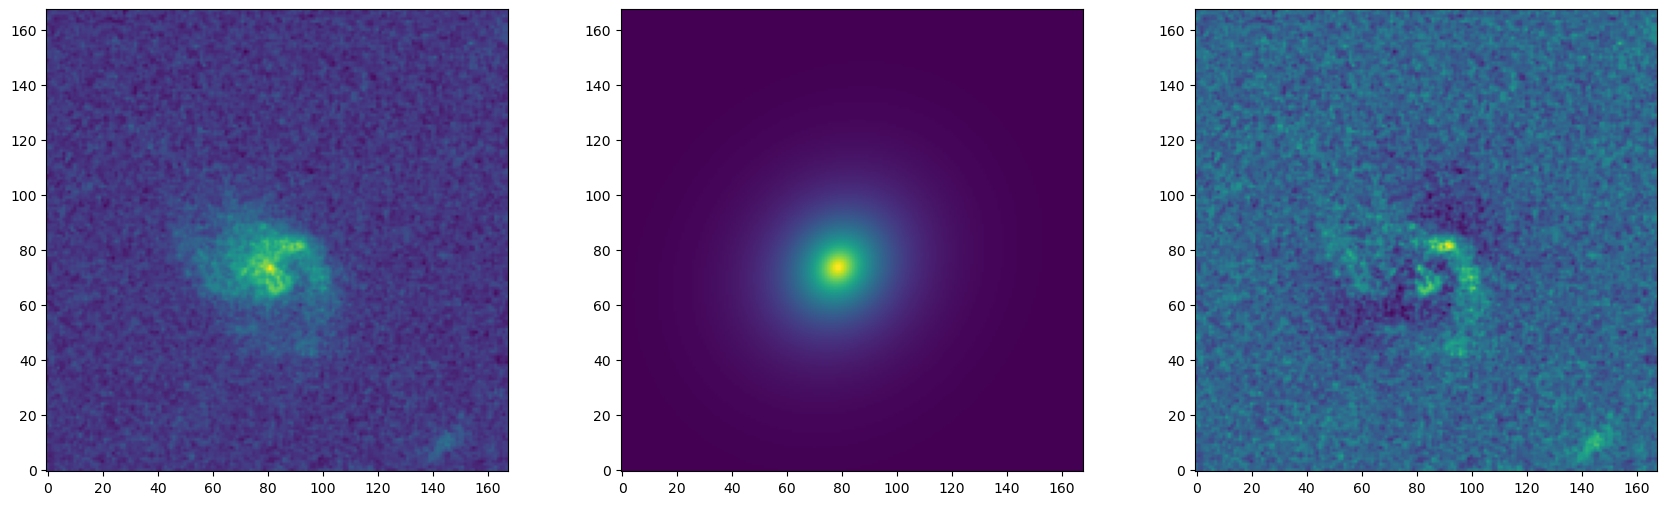

galsim.Shear(g1=-0.0016063272518333322,g2=0.06608758951134648)
{'x0': -5.033829352625995, 'y0': -9.900155788448536, 'sini': 0.48518389183808686, 'theta_int': 45.70095114816825, 'flux': 57.72755580967734, 'rs': 0.4234569653615874}


In [125]:
# Playground for fitting.
# Try loading, displaying, and then fitting an image.
#plt.imshow(imap_dict['data'],origin='lower')


imap_pars = {}
imap_pars['x0'] = -5.
imap_pars['y0'] = -10. 
imap_pars['flux'] = np.sum(imap_dict['data'])
imap_pars['rs'] = .5
imap_pars['sini'] = 0.9
imap_pars['theta_int'] = 45
Nrow, Ncol = imap_dict['data'].shape
Nx, Ny = Ncol, Nrow

# Now try running an optimizer

def fi(pars):
    ipars = imap_theta2pars(pars)
    r = imap_residuals(ipars, imap_dict['data'], imap_dict['hdr'], imap_dict['weights'], imap_dict['mask'], psf=imap_dict['psf'])
    return r

# Parameter order:
'''
pars['x0'],
pars['y0'],
pars['sini'],
pars['theta_int'],
pars['flux'],
pars['rs'],
'''
lobounds = np.zeros(6)
hibounds = np.repeat(np.inf,6)
#x0
lobounds[0] = -50
hibounds[0] = 50
#y0
lobounds[1] = -50
hibounds[1] = 50

#sini
lobounds[2] = 0.
hibounds[2] = 1.

# theta_int
lobounds[3] = -90
hibounds[3] = 90

startpars = imap_pars2theta(imap_pars)
result = least_squares(fi,startpars,verbose=1, bounds=  (lobounds,hibounds))

bestfit_im = imap_theta2pars(result.x)
imap_model = get_imap_model(bestfit_im, imap_dict['hdr'],Nx,Ny,psf=imap_dict['psf'])
imap_resid = imap_residuals(bestfit_im, imap_dict['data'], imap_dict['hdr'], imap_dict['weights'], imap_dict['mask'], psf=imap_dict['psf'])
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1,figsize=(21,6))
ax1.imshow(imap_dict['data'],origin='lower')
ax2.imshow(imap_model,origin='lower')
ax3.imshow(imap_resid.reshape(imap_model.shape),origin='lower')
plt.show()

mom=gs.Image(imap_model,scale=0.01).FindAdaptiveMom()
print(mom.observed_shape)
print(bestfit_im)

`ftol` termination condition is satisfied.
Function evaluations 24, initial cost 1.8659e+06, final cost 3.7068e+04, first-order optimality 1.44e+00.


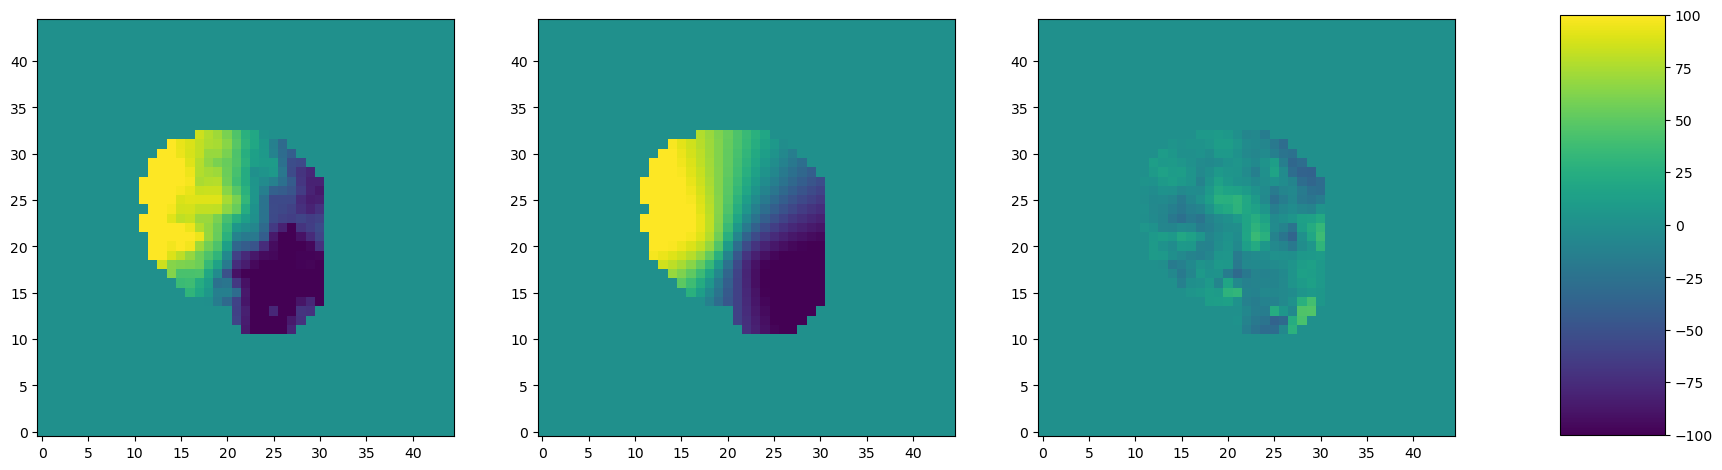

{'v0': 4.2160932313964103e-22, 'vcirc': 494.3796757823628, 'rscale': 1.8949004306407105, 'sini': -0.2703432765877604, 'theta_int': -0.4650514504809099, 'x0': -1.9441146518958887, 'y0': -2.3912304632118895, 'g1': 0.0, 'g2': 0.0, 'r_unit': Unit("pix"), 'v_unit': Unit("km / s"), 'pix_scale': 1}
R22:9.316053237954923
V2.2:116.57857735240657
VTF:[142.30552079]
sini from V2.2:[0.81921331]


In [126]:
# Now fit the velocity field.
vpars_init = {
        'v0': 0.,
        'vcirc': 220.,
        'rs': 0.1,
        'sini': -0.65,
        'theta_int': 45*np.pi/180.,
        'x0': 0.,
        'y0': 0.,
        'g1': 0.0,
        'g2': 0.0,
        'r_unit': u('pixel'),
        'v_unit': u('km/s'),
    }

'''
Parameter order of velocity vector
        pars['v0'],
        pars['vcirc'],
        pars['rs'],
        pars['sini'],
        pars['theta_int'],
        pars['x0'],
        pars['y0'],
'''
#vlobounds = np.array([0.,    0.,    0.,   -.7,-np.pi/2.,-50.,-50.])
#vhibounds = np.array([np.inf,np.inf,np.inf,-.6, np.pi/2., 50., 50.])
#vlobounds = np.array([0.,    210,    0.,   -1,-np.pi/2.,-50.,-50.])
#vhibounds = np.array([np.inf,250,np.inf,1., np.pi/2., 50., 50.])
vlobounds = np.array([0.,    0.,    0.,   -1,-np.pi/2.,-50.,-50.])
vhibounds = np.array([np.inf,np.inf,2.2*bestfit_im['rs']/0.1,1, np.pi/2., 50., 50.])


#vlobounds = np.array([0.,    0.,    0.,   -1,-np.pi/2.,-50.,-50.])
#vhibounds = np.array([np.inf,np.inf,np.inf,1, np.pi/2., 50., 50.])

vTF = estimate_vtf(np.log10(obj_data['catalog']['MASS']))

def fv(pars):
    vpars = vmap_theta2pars(pars)
    r = vmap_residuals(vpars, vmap_dict['data'], vmap_dict['hdr'], vmap_dict['weights'], vmap_dict['mask'], psf=vmap_dict['psf'],vTF=vTF)
    return r


startpars = vmap_pars2theta(vpars_init)
result = least_squares(fv,startpars,verbose=1, bounds=  (vlobounds,vhibounds))

bestfit_v = vmap_theta2pars(result.x)

Nrow, Ncol = vmap_dict['data'].shape
Nx, Ny = Ncol, Nrow
X, Y = build_map_grid(Nx, Ny, indexing='xy')

vmap = VelocityMap('offset', bestfit_v)
vmap_model = vmap('obs', X, Y) # render in the obs frame
vmap_resid = vmap_residuals(bestfit_v, vmap_dict['data'], vmap_dict['hdr'], vmap_dict['weights'], vmap_dict['mask'], psf=vmap_dict['psf'])


#plt.imshow(vmap_dict['data'],origin='lower')
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1,figsize=(21,6))
vplotscale = 100
ax1.imshow(vmap_dict['data'],origin='lower',vmin=-vplotscale,vmax=vplotscale)
ax2.imshow(vmap_model*vmap_dict['mask'],origin='lower',vmin=-vplotscale,vmax=vplotscale)
im = ax3.imshow(vmap_resid.reshape(vmap_model.shape),origin='lower',vmin=-vplotscale,vmax=vplotscale)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()
print(bestfit_v)

v22 = get_v22(bestfit_v,bestfit_im)
print(f"V2.2:{v22}")
print(f"VTF:{vTF}")
print(f"sini from V2.2:{v22/vTF}")